In [31]:
from helpers import load_csv_data
import os
import numpy as np
import matplotlib.pyplot as plt

In [76]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data('./data/dataset/dataset', sub_sample = False)

In [286]:
# Remove columns with more than lim_col [%] of Nans
lim_col = 0.2
percentages = np.sum(np.isnan(x_train), axis = 0) / x_train.shape[0]
x_tr = x_train[:, percentages < lim_col]

In [287]:
# Remove datapoints (rows) with one or multiple Nans
keep_idxs = (np.sum(np.isnan(x_tr), axis = 1)) == 0
x_tr = x_tr[keep_idxs, :]
y_tr = y_train[keep_idxs] 

In [290]:
# Remove features with 0 variance
var = np.var(x_tr, axis = 0)
x_tr = x_tr[:, var != 0]

In [291]:
# Remove highly correlated features
lim_corr = 0.95
corr_tri = np.triu(np.abs(np.corrcoef(x_tr, rowvar = False)), k = 1) # upper triangular correlation matrix (diagonal zeroed as well)
max_corr = np.max(corr_tri, axis = 0)
x_tr = x_tr[:, max_corr < lim_corr] # 118 features


In [294]:
# Remove features that have very low correlation with target value
lim_corr = 0.2
x_y = np.c_[y_tr, x_tr]

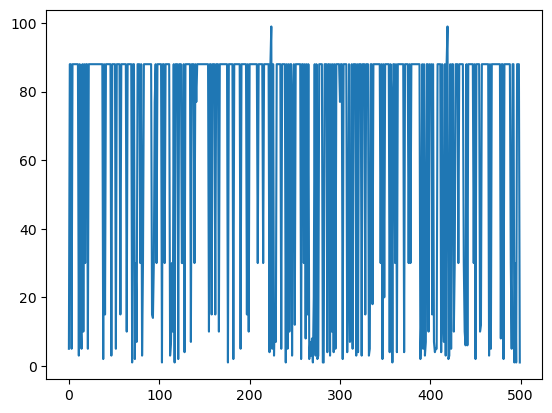

In [276]:
plt.plot(x_tr[:,9][:500])
#x_tr[:,5]